<a href="https://colab.research.google.com/github/simran-bhella/Quora-Question-Pairs/blob/main/BERT_quora_deduplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BERT Fine-tuning for Quora Question Pair Deduplication

In [ ]:
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu121
!pip install transformers
!pip install pandas
!pip install scikit-learn
!pip install ipywidgets

Looking in indexes: https://download.pytorch.org/whl/cu121

# Data Preprocessing

In [ ]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch
import pandas as pd

def preprocess_data(file_path):
    data = pd.read_csv(file_path)

    # Sample 25% of the data
    data_sampled = data.sample(frac=0.25, random_state=42)

    data_sampled = data_sampled.dropna(subset=['question1', 'question2'])
    data_sampled['question1'] = data_sampled['question1'].str.lower().str.replace('[^\w\s]', '', regex=True)
    data_sampled['question2'] = data_sampled['question2'].str.lower().str.replace('[^\w\s]', '', regex=True)
    return data_sampled

# Load and preprocess the dataset
data = preprocess_data('train.csv')

# Split the data into training and testing+validation sets (60% train, 40% test+val)
#train_data is 15% of the original set
train_data, test_val_data = train_test_split(data, test_size=0.4, random_state=42)

# Further split the testing/validation set into testing and validation sets (50% test, 50% val of the 10%, each 5%)
test_data, val_data = train_test_split(test_val_data, test_size=0.5, random_state=42)



# Tokenizing and Batching

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

class QuestionPairsDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        question1 = self.dataframe.iloc[idx]['question1']
        question2 = self.dataframe.iloc[idx]['question2']
        label = torch.tensor(self.dataframe.iloc[idx]['is_duplicate'], dtype=torch.float32)

        # Tokenize and encode questions for BERT
        encoding1 = tokenizer.encode_plus(question1, return_tensors='pt', max_length=512, padding='max_length', truncation=True)
        encoding2 = tokenizer.encode_plus(question2, return_tensors='pt', max_length=512, padding='max_length', truncation=True)

        return encoding1['input_ids'], encoding1['attention_mask'], encoding2['input_ids'], encoding2['attention_mask'], label



#Create DataLoaders

In [ ]:
train_dataset = QuestionPairsDataset(train_data)
test_dataset = QuestionPairsDataset(test_data)
val_dataset = QuestionPairsDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Building the Neural Network with BERT Model

In [ ]:
import torch.nn as nn

class QuestionPairClassifier(nn.Module):
    def __init__(self):
        super(QuestionPairClassifier, self).__init__()
        self.bert = bert_model
        self.fc = nn.Linear(768 * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        with torch.no_grad():
            emb1 = self.bert(input_ids1, attention_mask=attention_mask1).pooler_output
            emb2 = self.bert(input_ids2, attention_mask=attention_mask2).pooler_output

        combined_emb = torch.cat((emb1, emb2), 1)
        x = self.fc(combined_emb)
        x = self.sigmoid(x)
        return x

# Ensure that model uses GPU locally

In [ ]:
!nvidia-smi

Sun Nov 26 15:22:40 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.92                 Driver Version: 545.92       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   37C    P5              32W / 220W |   3753MiB /  8192MiB |     15%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
print(f"Using device: {device}")

# Move the model to the chosen device
model = QuestionPairClassifier().to(device)

2.1.0+cu121
12.1
True
Using device: cuda


#Model Training

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Lists to store loss per epoch
train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, device, epochs=3):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for input_ids1, attention_mask1, input_ids2, attention_mask2, labels in train_loader:
            input_ids1, attention_mask1, input_ids2, attention_mask2, labels = \
                input_ids1.to(device), attention_mask1.to(device), input_ids2.to(device), attention_mask2.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids1.squeeze(1), attention_mask1.squeeze(1), input_ids2.squeeze(1), attention_mask2.squeeze(1))
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        total_val_loss = 0
        predictions, true_labels = [], []

        with torch.no_grad():
            for input_ids1, attention_mask1, input_ids2, attention_mask2, labels in val_loader:
                input_ids1, attention_mask1, input_ids2, attention_mask2, labels = \
                    input_ids1.to(device), attention_mask1.to(device), input_ids2.to(device), attention_mask2.to(device), labels.to(device)

                outputs = model(input_ids1.squeeze(1), attention_mask1.squeeze(1), input_ids2.squeeze(1), attention_mask2.squeeze(1))
                loss = criterion(outputs, labels.unsqueeze(1))
                total_val_loss += loss.item()

                predicted_labels = (outputs.squeeze() > 0.5).long()
                predictions.extend(predicted_labels.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        val_accuracy = accuracy_score(true_labels, predictions)
        val_precision = precision_score(true_labels, predictions)
        val_recall = recall_score(true_labels, predictions)
        val_f1 = f1_score(true_labels, predictions)

        print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss}, Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")


# Train the model and collect losses
train_model(model, train_loader, val_loader, device,3)


Epoch 1, Training Loss: 0.01935825787806907
Epoch 1, Validation Loss: 0.019428776347221434, Accuracy: 0.6463517190205293, Precision: 0.7224669603524229, Recall: 0.08685290613001456, F1 Score: 0.15506441318993025
Epoch 2, Training Loss: 0.019283412492320646
Epoch 2, Validation Loss: 0.020383031097580058, Accuracy: 0.6134553549344546, Precision: 0.4874507164150399, Recall: 0.6711240566662253, F1 Score: 0.5647281639928698
Epoch 3, Training Loss: 0.019287964829377467
Epoch 3, Validation Loss: 0.018958931806032652, Accuracy: 0.6739549839228296, Precision: 0.5741140215716487, Recall: 0.49331391500066196, F1 Score: 0.5306558427686392


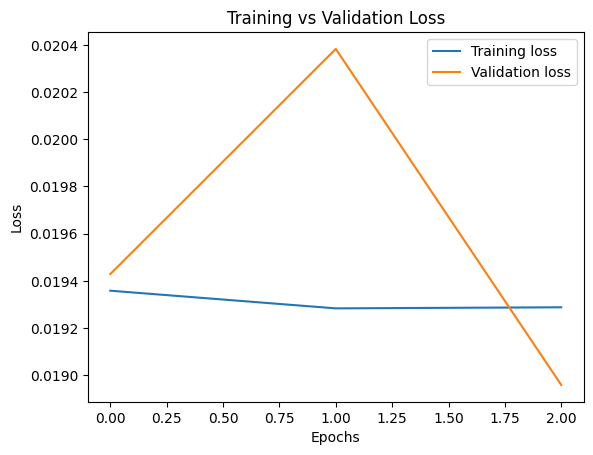

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.show()

plot_loss(train_losses, val_losses)

#Evaluate Model on Test Set

In [ ]:
predictions, true_labels = [], []
def evaluate_on_test(model, test_loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for input_ids1, attention_mask1, input_ids2, attention_mask2, labels in test_loader:
            input_ids1, attention_mask1, input_ids2, attention_mask2, labels = \
                input_ids1.to(device), attention_mask1.to(device), input_ids2.to(device), attention_mask2.to(device), labels.to(device)

            outputs = model(input_ids1.squeeze(1), attention_mask1.squeeze(1), input_ids2.squeeze(1), attention_mask2.squeeze(1))
            loss = nn.BCELoss()(outputs, labels.unsqueeze(1))

            total_loss += loss.item()
            predicted_labels = (outputs.squeeze() > 0.5).long()
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy, precision, recall, f1 = (accuracy_score(true_labels, predictions),
                                        precision_score(true_labels, predictions),
                                        recall_score(true_labels, predictions),
                                        f1_score(true_labels, predictions))

    return avg_loss, accuracy, precision, recall, f1

# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate_on_test(model, test_loader, device)
print(f"Test Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}")


Test Loss: 0.018847178452161415, Accuracy: 0.6752745621846246, Precision: 0.5669554643562852, Recall: 0.5010073875083949, F1 Score: 0.5319452367370222


#Visualize Test Results

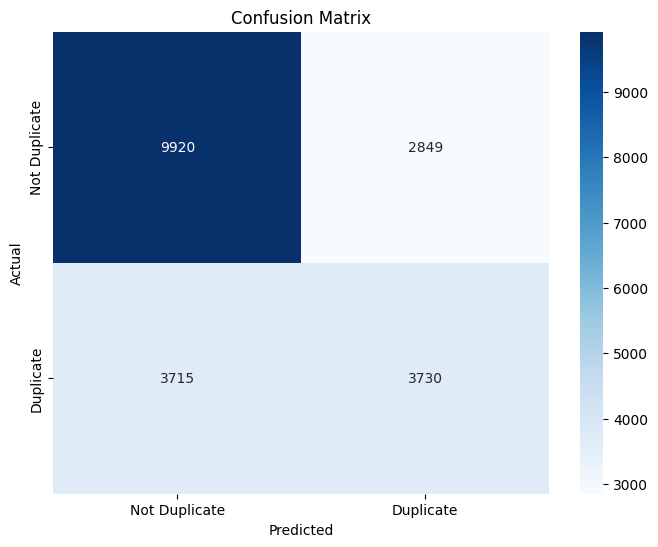

<Axes: >

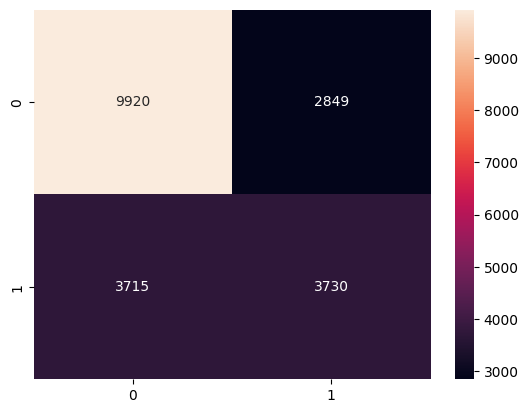

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Duplicate', 'Duplicate'], yticklabels=['Not Duplicate', 'Duplicate'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d')


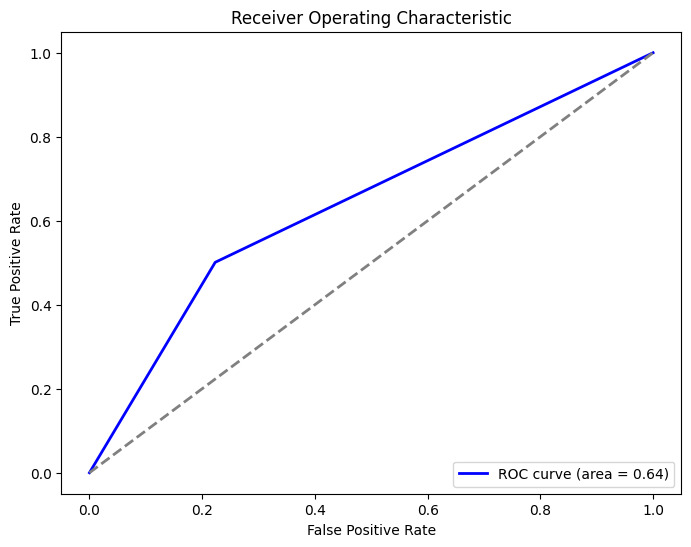

In [ ]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
